# Some preliminary python code

In [1]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Univariate continuous -> discrete filter: Breast cancer classification dataset

As an example, we will consider the breast cancer classification dataset. This classification dataset has 30 continuous features with 569 samples. 

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

data  = load_breast_cancer()

# We split the dataset with 15% as a test, using stratified to ensure the train and test sets
# both have approximately the same statistics as the whole dataset
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], stratify=data['target'], test_size=0.15)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Baseline without feature selection

**Without** feature selection, we use all the 30 features for the RBF SVC

In [3]:
# Train the classification SVM
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 

# Finally, we estimate the accuracy on the test set
y_test_pred = clf.predict(X_test)
test_accuracy = 100 * (y_test_pred == y_test).sum() / y_test.size
print("Accuracy on the test set : {:.2f} %".format(test_accuracy))

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(StandardScaler(), 
                    SVC(kernel='rbf'))
scores = cross_val_score(clf, data['data'], data['target'], cv=4)
print("Real risk by cross validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy on the test set : 96.51 %
Real risk by cross validation: 0.97 (+/- 0.01)


## Compute the ANOVA F-values

(array([[0.19862277, 0.54792488, 0.32875493, 0.10273592, 0.02739624,
         0.01369812, 0.00684906, 0.00684906, 0.        , 0.        ],
        [0.32143118, 0.43942491, 0.27667494, 0.11799373, 0.04068749,
         0.02441249, 0.        , 0.0081375 , 0.        , 0.00406875]]),
 array([-1.54311422, -0.73197303,  0.07916816,  0.89030936,  1.70145055,
         2.51259174,  3.32373293,  4.13487412,  4.94601532,  5.75715651,
         6.5682977 ]),
 <a list of 2 BarContainer objects>)

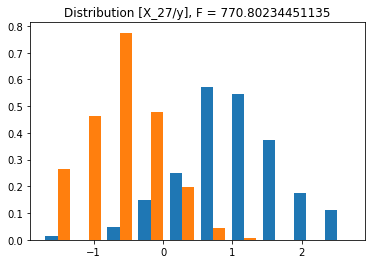

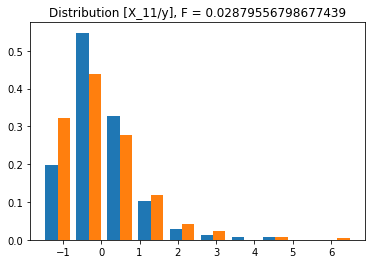

In [4]:
# Compute the F-valuues
f_values = f_classif(X_train, y_train)[0]

# Sort the F-values
sorted_idx = np.argsort(f_values)

highest_F_idx = sorted_idx[-1]
lowest_F_idx = sorted_idx[0]

# Extract the positive and negative samples masks
pos_samples = y_train == 0
neg_samples = np.logical_not(pos_samples)

# Plot
n_bins = 10
plt.figure()
plt.title(f"Distribution [X_{highest_F_idx}/y], F = {f_values[highest_F_idx]}")
plt.hist([X_train[pos_samples, highest_F_idx],
          X_train[neg_samples, highest_F_idx]],
         n_bins, density=True,
         histtype='bar',
         color=['tab:blue','tab:orange'],
         label=['Pos', 'Neg'])

plt.figure()
plt.title(f"Distribution [X_{lowest_F_idx}/y], F = {f_values[lowest_F_idx]}")
plt.hist([X_train[pos_samples, lowest_F_idx],
          X_train[neg_samples, lowest_F_idx]],
         n_bins, density=True,
         histtype='bar',
         color=['tab:blue','tab:orange'],
         label=['Pos', 'Neg'])


## Feature selection

**With** feature selection, where 3 of the features which have the highest ANOVA are selected. In this selection, denoting X the considered feature and y the discrete target, we analyze the distributions of P(X / y) and ask, informally the following question : is the distribution of the feature value significantly dependent on the class ? 

In [5]:
# We perform feature selection from the training set
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)

# Print out which are the selected features
selected_indices = selector.get_support(indices=True)
names_selected_indices = [data['feature_names'][i] for i in selected_indices]
print("The selector selected {} features, which have the indices {}, i.e. {}".format(len(selected_indices), selected_indices, names_selected_indices))

# We reduce the training set 
X_train_red = selector.transform(X_train)

# Train the classification SVM
clf = SVC(kernel='rbf')
clf.fit(X_train_red, y_train) 

# Finally, we estimate the accuracy on the test set
y_test_pred = clf.predict(selector.transform(X_test))
test_accuracy = 100 * (y_test_pred == y_test).sum() / y_test.size
print("Accuracy on the test set : {:.2f} %".format(test_accuracy))

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(StandardScaler(), 
                    SelectKBest(f_classif, k=3),
                    SVC(kernel='rbf'))
scores = cross_val_score(clf, data['data'], data['target'], cv=4)
print("Real risk by cross validation: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


The selector selected 3 features, which have the indices [20 22 27], i.e. ['worst radius', 'worst perimeter', 'worst concave points']
Accuracy on the test set : 95.35 %
Real risk by cross validation: 0.95 (+/- 0.02)
